In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

In [3]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [5]:
import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split


# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=3)
df_imputed = knn_imputer.fit_transform(df)


# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)


# Features & Target
x = df_imputed[[
    'Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min', 'Fraction inspired oxygen_max', \
    'Glucose_mean', 'Glucose_min', 'Glucose_max', \
    'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',\
    'Mean blood pressure_mean', 'Mean blood pressure_min', 'Mean blood pressure_max', \
    'Diastolic blood pressure_mean', 'Diastolic blood pressure_min', 'Diastolic blood pressure_max',\
    'Systolic blood pressure_mean', 'Systolic blood pressure_min', 'Systolic blood pressure_max',\
    'Oxygen saturation_mean', 'Oxygen saturation_min', 'Oxygen saturation_max',\
    'Respiratory rate_mean', 'Respiratory rate_min', 'Respiratory rate_max',\
    'Temperature_mean', 'Temperature_min', 'Temperature_max',\
    'Weight_mean', 'Weight_min', 'Weight_max',\
    'pH_mean', 'pH_min', 'pH_max']]
y = df_imputed['mortality']


# Applying SMOTE
smote = SMOTE(random_state = 42)
x_resampled, y_resampled = smote.fit_resample(x, y)


print('Original Dataset Shape:', y.value_counts())
print('\nResampled Dataset Shape:', y_resampled.value_counts())


print ('\n-------------------------------------------------------------------')
# Function to Detect Outliers using IQR
def detect_outlier_iqr(data):
  outliers = {}
  for column in df.columns:
      Q1 = data[column].quantile(0.25)
      Q3 = data[column].quantile(0.75)
      IRQ = Q3 - Q1
      lower_bound = Q1 - 1.5*IRQ
      upper_bound = Q3 + 1.5*IRQ
      outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
  return outliers

# Combine feataures and target variable for outlier detection
resampled_data = pd.DataFrame(x_resampled, columns=x.columns)
resampled_data['mortality'] = y_resampled

# Checking for Outliers in the Resampled Data
outliers_in_resampled = detect_outlier_iqr(pd.DataFrame(resampled_data))
for feature, outliers in outliers_in_resampled.items():
    print(f"Outliers detected in'{feature}':")
    print(outliers)
    print('\n~~~~~~~~~~~~~~~~~~~~~')




Resampled Dataset Shape: 1.0    4232
0.0    4232
Name: mortality, dtype: int64

-------------------------------------------------------------------
Outliers detected in'Fraction inspired oxygen_mean':
      Fraction inspired oxygen_mean  Fraction inspired oxygen_min  \
60                         1.000000                      1.000000   
65                         1.000000                      1.000000   
98                         1.000000                      1.000000   
118                        0.862500                      0.700000   
158                        0.833333                      0.500000   
...                             ...                           ...   
8279                       0.875009                      0.500075   
8308                       0.830007                      0.807035   
8338                       0.815078                      0.500000   
8429                       0.916121                      0.374937   
8447                       0.832788    

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 975, number of negative: 2977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246711 -> initscore=-1.116234
[LightGBM] [Info] Start training from score -1.116234
LightGBM Model accuracy score: 0.7599
Training set score: 0.9752
Test set score: 0.7599
Confusion matrix

 [[1173   82]
 [ 325  115]]

True Positives(TP) =  1173

True Negatives(TN) =  115

False Positives(FP) =  82

False Negatives(FN) =  325
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      1255
         1.0       0.58      0.26      0.36       440

    accuracy          

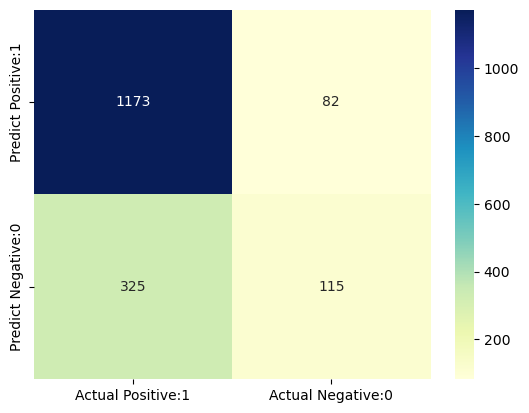

In [14]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces



In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])



# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')



from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


0.0    0.749424
1.0    0.250576
Name: mortality, dtype: float64


<Axes: >

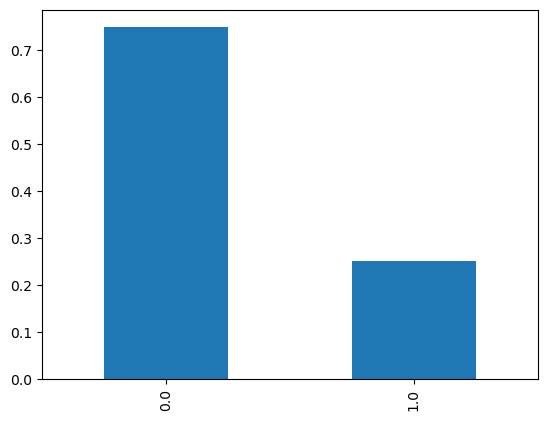

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
x = x.fillna(x.mean(skipna=True)).values
x /= x.mean()
y = df.mortality.values

In [5]:
#def log_logistic_fn(x):
#    return np.log(1+np.exp(-x)) 


class logisticModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __logistic_loss(self,param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*logistic.logcdf(score, loc=0, scale=1) - (1-y)*logistic.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__logistic_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__logistic_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return logistic.cdf(score, loc=0, scale=1)


class probitModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __probit_loss(self, param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*norm.logcdf(score, loc=0, scale=1) - (1-y)*norm.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__probit_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__probit_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return norm.cdf(score, loc=0, scale=1)

In [6]:
probit = probitModel()
result, loss_values = probit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927430849441969
Current loss: 0.6920101815560072
Current loss: 0.6858609345892607
Current loss: 0.6744141959070241
Current loss: 0.6555567679707328
Current loss: 0.6355197730432752
Current loss: 0.6263406461037592
Current loss: 0.6194067428116863
Current loss: 0.6142409076659513
Current loss: 0.6043415953399186
Current loss: 0.5866552758331277
Current loss: 0.5628595864196653
Current loss: 0.5593466508950318
Current loss: 0.5589331796434657
Current loss: 0.558149612427599
Current loss: 0.5520787754656873
Current loss: 0.5499190360384063
Current loss: 0.547229143431688
Current loss: 0.5462303307515513
Current loss: 0.5460148747671772
Current loss: 0.545715261471462
Current loss: 0.5452207029855193
Current loss: 0.5446470358822427
Current loss: 0.544579691893368
Current loss: 0.5445501158189461
Current loss: 0.5444966657809716
Current loss: 0.5443993695755704
Current loss: 0.5442255773599043
Current loss: 0.5439320997024457
Current loss: 0.5435373473112053
Current loss: 

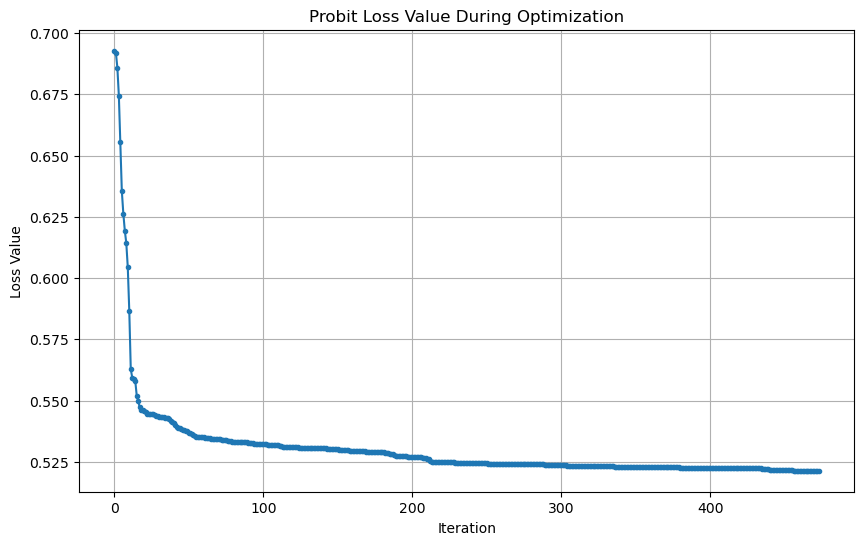

In [7]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

(array([ 344., 1920., 1786.,  921.,  422.,  164.,   57.,   21.,    9.,
           3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

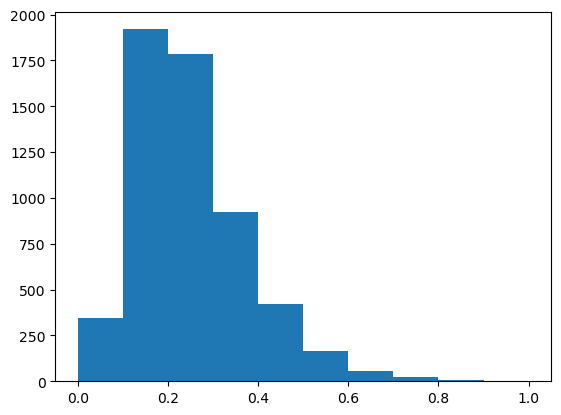

In [8]:
plt.hist(probit.predict(x))

In [9]:
logit = logisticModel()
result, loss_values = logit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927794968148143
Current loss: 0.6897525862668715
Current loss: 0.6846150641489323
Current loss: 0.6412695874903189
Current loss: 0.6197338760640024
Current loss: 0.5879432360391693
Current loss: 0.5747297710542044
Current loss: 0.5692222679922667
Current loss: 0.5666178005151807
Current loss: 0.5634633071549277
Current loss: 0.5628223621470703
Current loss: 0.5627432816096835
Current loss: 0.5620764118766902
Current loss: 0.5609964184113865
Current loss: 0.5605664213823317
Current loss: 0.5600051696791752
Current loss: 0.5592841384907206
Current loss: 0.5585817527312442
Current loss: 0.5575696860193171
Current loss: 0.5574905499683771
Current loss: 0.5567463921466279
Current loss: 0.5553705747246096
Current loss: 0.5544774072189647
Current loss: 0.552966703810709
Current loss: 0.5506536047374448
Current loss: 0.5500445758058792
Current loss: 0.5497762253119355
Current loss: 0.5492984249276213
Current loss: 0.5485664545477493
Current loss: 0.5481670785920325
Current los

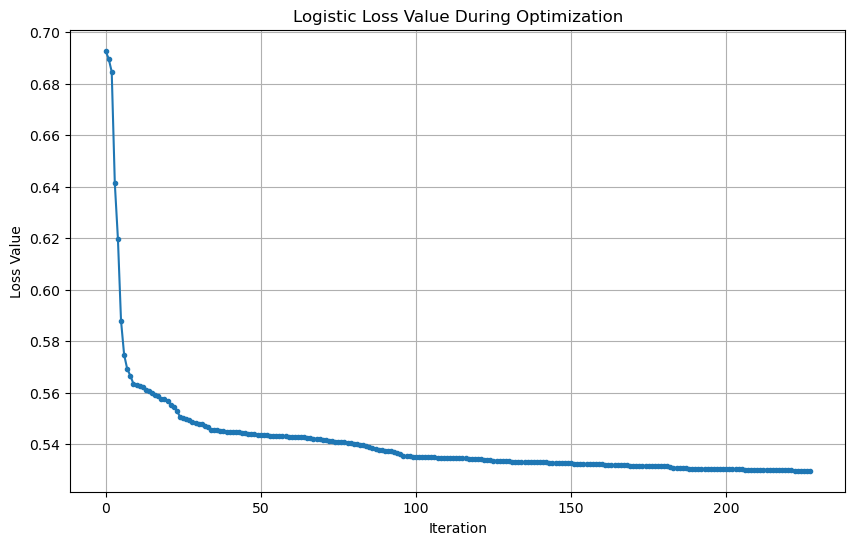

In [10]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

In [15]:
logit.predict(x)

array([0.21802879, 0.19470473, 0.21359502, ..., 0.16214609, 0.23223332,
       0.21606305])

(array([2.200e+02, 1.898e+03, 1.987e+03, 9.340e+02, 3.980e+02, 1.660e+02,
        3.500e+01, 8.000e+00, 0.000e+00, 1.000e+00]),
 array([1.05972483e-40, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

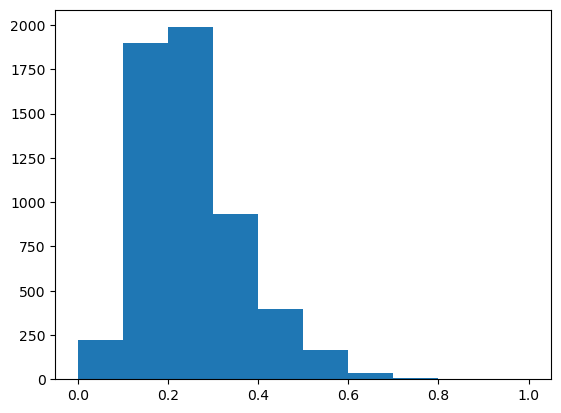

In [16]:
plt.hist(logit.predict(x))

In [17]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x, y)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [18]:
from sklearn.metrics import log_loss

log_loss(y, model.predict_proba(x), eps=1e-15)

0.5363497888711615